In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_concat_raws(folder_path):
    raw_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.fif')]
    raws = [mne.io.read_raw_fif(f, preload=True) for f in raw_files]
    concatenated_raw = mne.concatenate_raws(raws)
    return concatenated_raw

In [3]:
raw = load_and_concat_raws("/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/cyfry")

# 1. Basic Information
raw.pick_types(eeg=True)
print(raw.info)
print(raw.ch_names)
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Data duration: {raw.n_times / raw.info['sfreq']} seconds")
print(f"Number of channels: {len(raw.ch_names)}")


<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, T3, T4, T5, T6, F7, F8
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 16
 projs: []
 sfreq: 250.0 Hz
>
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'F7', 'F8']
Sampling frequency: 250.0 Hz
Data duration: 4954.3 seconds
Number of channels: 16


In [4]:
# 2. Plot Raw Data
raw.plot(n_channels=len(raw.ch_names), scalings='auto', title='Raw Data Plot')

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


In [5]:
raw.apply_function(fun=lambda x: x * 10**(-6))
raw.filter(l_freq=1, h_freq=40)
raw.plot(n_channels=len(raw.ch_names), scalings='auto', title='Raw Data Plot after filtering and unit conversion')

[[5000    0    7]
 [5254    0    5]
 [7259    0    1]
 [8356    0    7]
 [8609    0    2]]


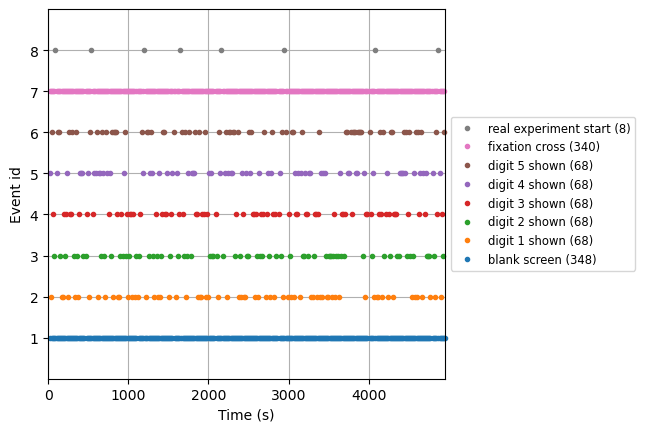

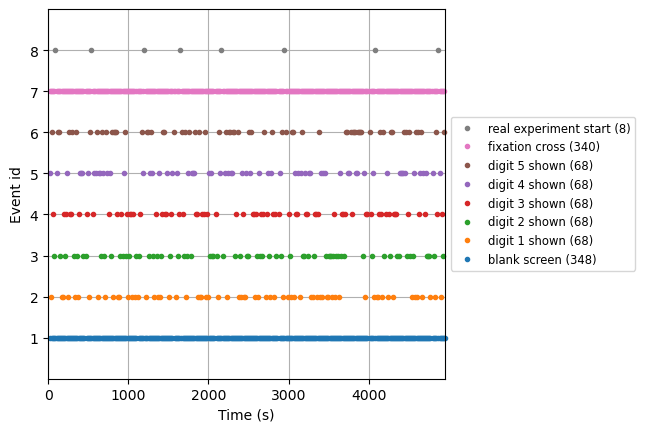

In [6]:
# 3. Event Exploration
events, event_dict = mne.events_from_annotations(raw)
print(events[:5])  # Print first 5 events
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'])


/home/grzesiek/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


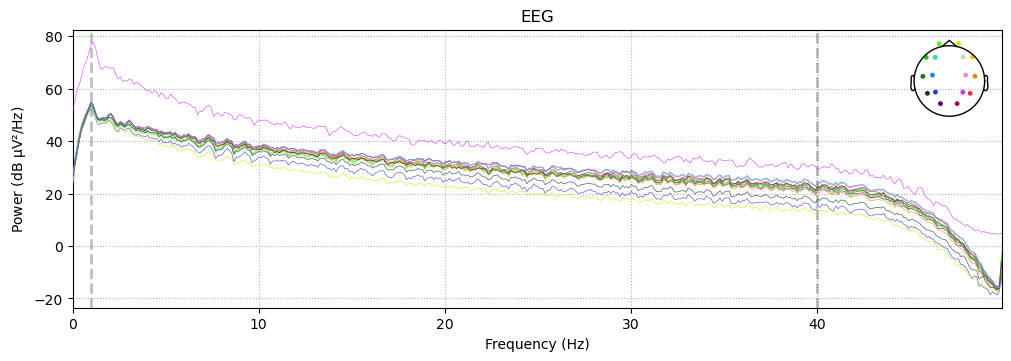

In [7]:
# 4. Channel Inspection
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=16)


In [11]:
# fig, ax = plt.subplots()
# psds, freqs = mne.time_frequency.psd_welch(raw, fmin=1, fmax=40, n_fft=2048)
# psds_mean = psds.mean(axis=0)
# ax.plot(freqs, psds_mean)
# ax.set_title('Power Spectral Density (PSD)')
# ax.set_xlabel('Frequency (Hz)')
# ax.set_ylabel('Power Spectral Density (dB)')

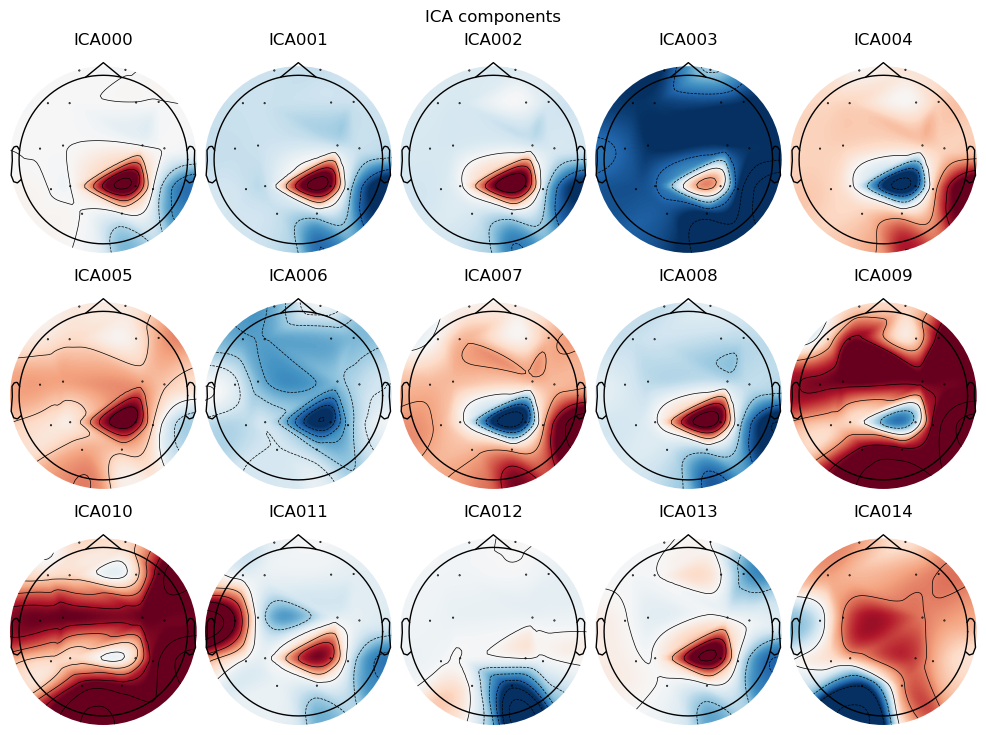

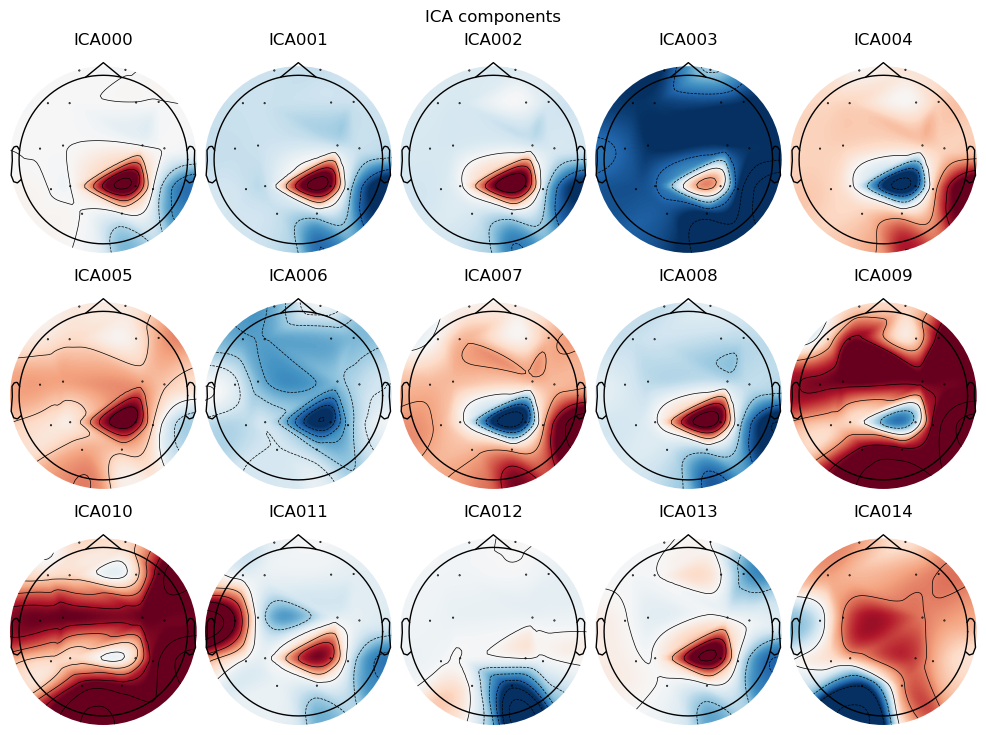

In [12]:

# 6. Artifact Detection
raw.plot(n_channels=16, butterfly=True)
ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter='auto')
ica.fit(raw)
ica.plot_components()

In [25]:
from scipy.stats import pearsonr
import pandas as pd
# Define frequency bands
freq_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# Create an empty DataFrame to hold the features
features = pd.DataFrame()

for band, (fmin, fmax) in freq_bands.items():
    psd = raw.compute_psd(fmin=fmin, fmax=fmax, n_fft=2048).get_data()
    psd_mean = psd.mean(axis=1)  # Mean power across the frequency band for each channel
    features[band] = psd_mean
    
# Get the event labels
event_ids = [2, 3, 4, 5, 6]

# Ensure the features and event labels are aligned (e.g., by epoch)
features['event'] = event_ids

# Compute correlation between features and labels
correlations = features.corr(method='pearson')
print(correlations)

# Plot correlation matrix with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between EEG Features and Event Labels')
plt.show()

ValueError: Length of values (5) does not match length of index (16)

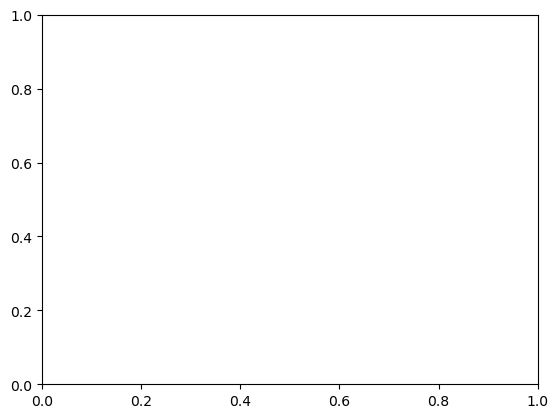

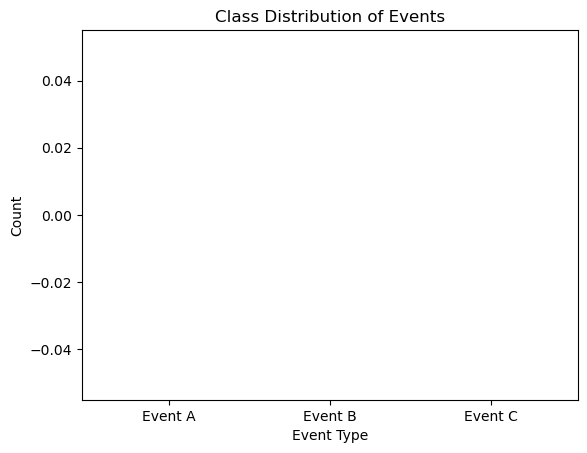

In [9]:

# 8. Class Distribution
event_counts = {key: len(events[events[:, 2] == val]) for key, val in event_dict.items()}
plt.figure()
plt.bar(event_counts.keys(), event_counts.values())
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.title('Class Distribution of Events')
plt.show()


In [10]:

# 9. Data Cleaning and Preprocessing
# High-pass filter to remove slow drifts
raw.filter(l_freq=1., h_freq=None)

# Low-pass filter to remove high-frequency noise
raw.filter(l_freq=None, h_freq=40.)

# Resample the data to a lower frequency (if necessary)
raw.resample(128, npad="auto")


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,"16 EEG, 3 misc, 1 Stimulus, 1 System status channel information (Triux systems)"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [ ]:

# 10. Extract epochs for analysis
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5, preload=True)
print(epochs)
epochs.plot(n_epochs=10, n_channels=10)

# Save cleaned data for later use
cleaned_file_path = '/path/to/cleaned_file.fif'
raw.save(cleaned_file_path, overwrite=True)